## Семинар 4: "Сверточные сети"

ФИО: 

In [2]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [36]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)

    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    for i in range(len(signal_convolved)):
        signal_convolved[i] = np.sum(signal[i : (i + len(kernel))] * kernel[::-1])

    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [37]:
from scipy.signal import convolve

np.random.seed(125)
signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

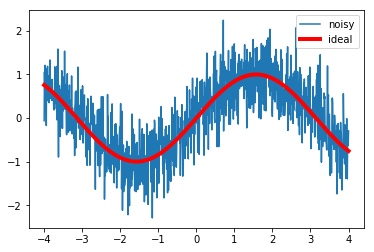

In [38]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [79]:
kernel = np.ones((75, )) / 75
denoised_signal = convolve(noisy_signal, kernel, 'same')

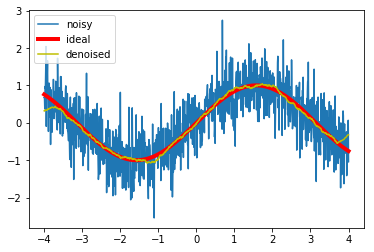

In [80]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

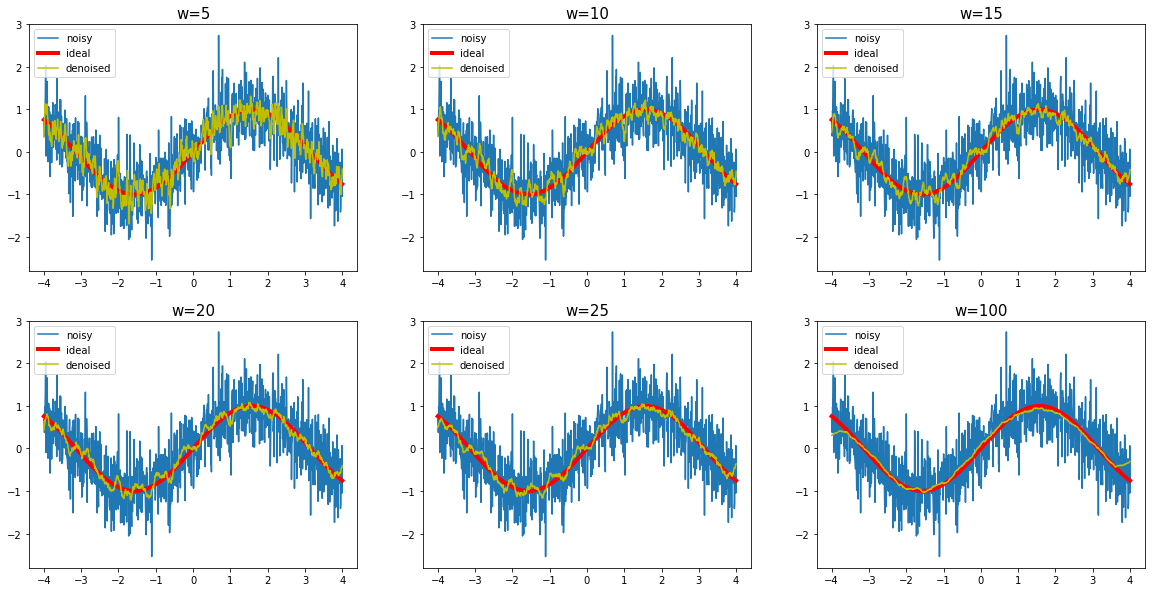

In [85]:
plt.figure(figsize=(20, 10))
for i, w in enumerate([5, 10, 15, 20, 25, 100]):
    plt.subplot(2, 3, i + 1)
    kernel = np.array([1. / w] * w)
    denoised_signal = convolve(noisy_signal, kernel, 'same')
    plt.plot(x, noisy_signal, label='noisy')
    plt.plot(x, signal, 'r', label='ideal', linewidth=4)
    plt.plot(x, denoised_signal, 'y', label='denoised')
    plt.title('w={}'.format(w), fontsize=15)
    plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [87]:
image = plt.imread('yareyare.jpg')

(720, 1280, 3)


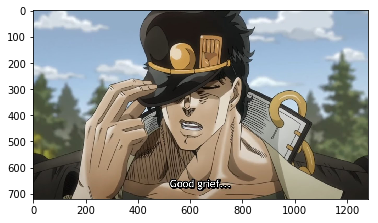

In [94]:
plt.imshow(image)
print(image.shape)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [103]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140]).reshape(1, 1, 3)
color_to_bw

array([[[ 0.2989,  0.587 ,  0.114 ]]])

In [122]:
convolve(image, color_to_bw, 'valid').shape

(720, 1280, 1)

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

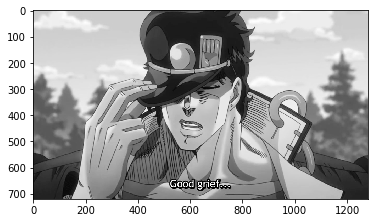

In [127]:
bw_image = convolve(image, color_to_bw, 'valid')[:, :, 0]
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [128]:
K_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
K_x = K_y.T

In [138]:
G_x = convolve(bw_image, K_x, 'valid')
G_y = convolve(bw_image, K_y, 'valid')
G = np.sqrt(G_x ** 2 + G_y ** 2)

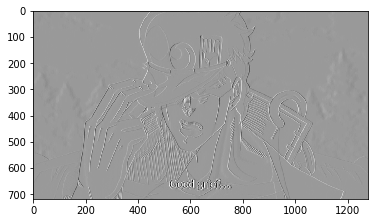

In [139]:
plt.imshow(G_x, cmap=plt.cm.Greys_r)

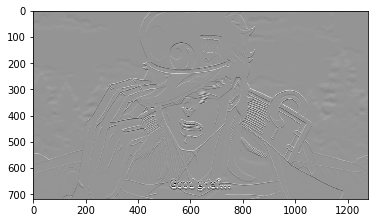

In [140]:
plt.imshow(G_y, cmap=plt.cm.Greys_r)

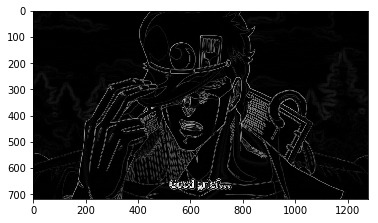

In [141]:
plt.imshow(G, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [297]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    new_im = np.zeros(signal.shape)
    for i, el in enumerate(kernel):
        new_im[:, :, i] = convolve(signal, el, 'valid').reshape(signal.shape[:2])
    return new_im.astype('uint8')

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [295]:
ker = np.array([0, 1, 0, 1, 0, 0, 0, 0, 1]).reshape(3, 1, 1, 3)
ker

array([[[[0, 1, 0]]],


       [[[1, 0, 0]]],


       [[[0, 0, 1]]]])

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

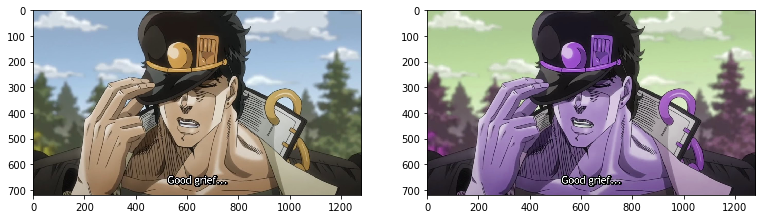

In [298]:
plt.figure(figsize=(20, 10))
new_im = t_convolve_bank(image, ker)
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.subplot(2, 3, 2)
plt.imshow(new_im)

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [364]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for c in range(image.shape[2]):
        for i in range(0, image.shape[0], w):
            for j in range(0, image.shape[1], w):
                res[i // w, j // w, c] = image[i : i + w, j : j + w, c].max()
    return res.astype('uint8')

def medianpool(image, w=2):
    assert(image.ndim == 3)
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for c in range(image.shape[2]):
        for i in range(0, image.shape[0], w):
            for j in range(0, image.shape[1], w):
                res[i // w, j // w, c] = np.median(image[i : i + w, j : j + w, c])
    return res.astype('uint8')

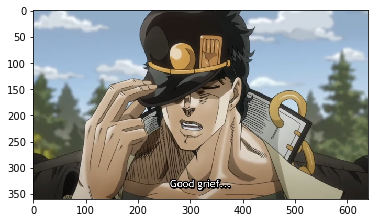

In [365]:
plt.imshow(medianpool(image))

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

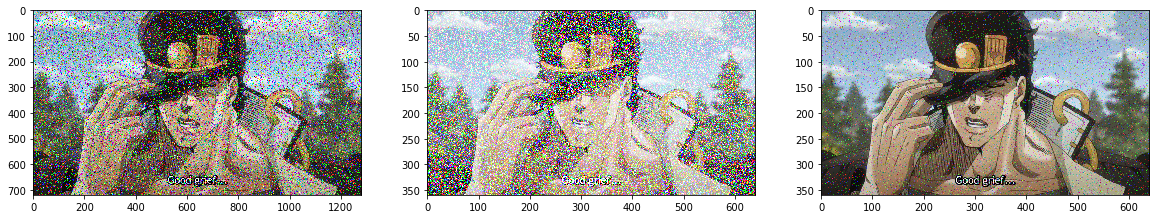

In [370]:
plt.figure(figsize=(20, 10))

noise_white = np.random.rand(*image.shape) > 0.9
noise_black = np.random.rand(*image.shape) > 0.9
sp_image = np.copy(image)
sp_image[np.where(noise_white)] = 255
sp_image[np.where(noise_black)] = 0

plt.subplot(2, 3, 1)
plt.imshow(sp_image)

plt.subplot(2, 3, 2)
plt.imshow(maxpool(sp_image))

plt.subplot(2, 3, 3)
plt.imshow(medianpool(sp_image))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Очевидно, что справляться будет медианпулинг лучше, тк шум имеет самые большие значения (255) и в случае макспулинга именно точки из шума будут выбираться в качестве новых точек изображения

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [371]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Processing...
Done!


In [372]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [373]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.254/0.239	Accuracy: 0.926/0.931


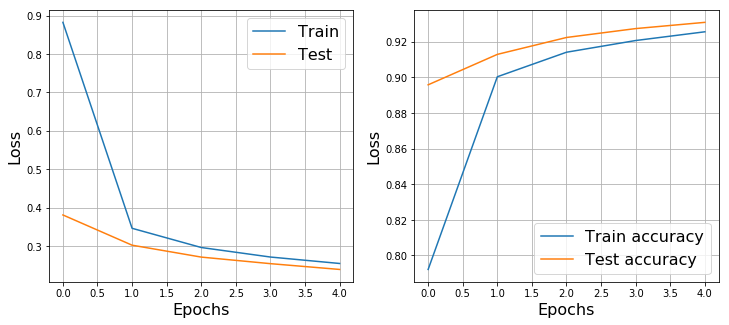

In [374]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [601]:
class FirstConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(FirstConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.ReLU(),
                                        )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        return x
    
class SecondConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(SecondConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(16, 32, 3, padding=1),
                                        )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.092/0.078	Accuracy: 0.973/0.977


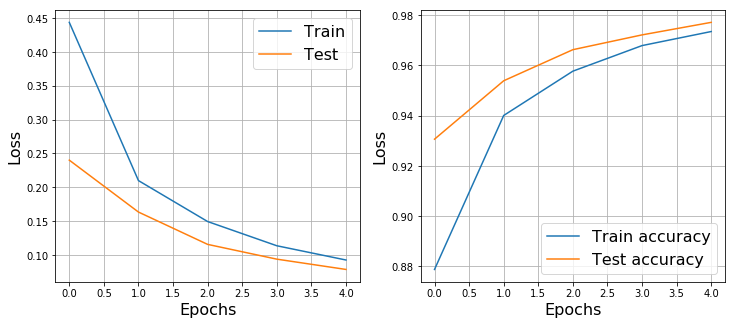

In [596]:
network1 = FirstConvClassifier(image_size=28)
train(network1, 5, 1e-4)

Epoch 4... (Train/Test) NLL: 0.065/0.057	Accuracy: 0.980/0.982


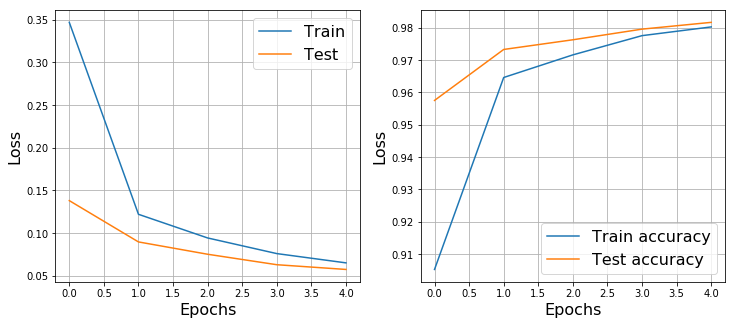

In [602]:
network2 = SecondConvClassifier(image_size=28)
train(network2, 5, 1e-4)

На полносвязной сети прямого распространения сходилось все <strong>ГОРАЗДО</strong> медленнее

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [666]:
def plot_inc_samples(network):
    wrong_X = []
    correct_y = []
    predicted_y = []
    logits = []
    for X, y in test_loader:
        prediction = network(X)
        prediction = prediction.data.numpy()
        for i in range(len(prediction)):
            if np.argmax(prediction[i]) != y[i].data.numpy():
                wrong_X.append(X[i])
                correct_y.append(y[i])
                predicted_y.append(np.argmax(prediction[i]))
                logits.append(prediction[i][y[i]])
    wrong_X = np.row_stack(wrong_X)
    correct_y = np.row_stack(correct_y)[:, 0]
    predicted_y = np.row_stack(predicted_y)[:, 0]
    logits = np.row_stack(logits)[:, 0]
    
    plt.figure(figsize=(10, 5))
    order = np.argsort(logits)
    for i in range(21):
        plt.subplot(3, 7, i+1)
        plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
        plt.axis('off')

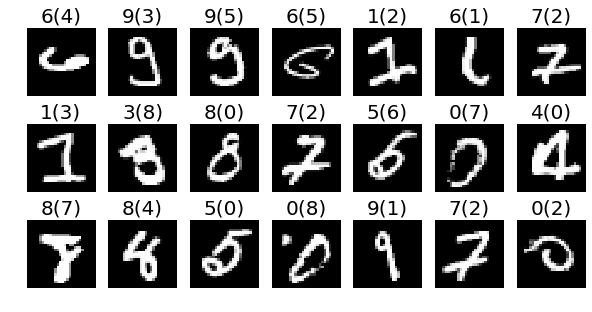

In [667]:
plot_inc_samples(network1)

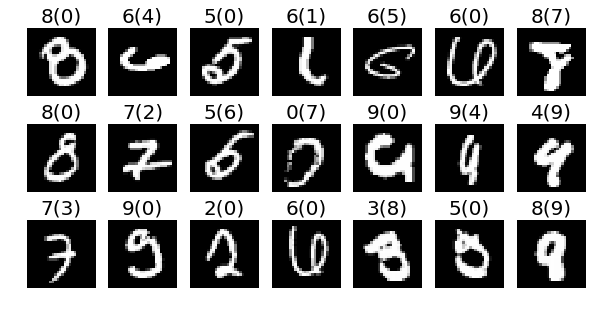

In [668]:
plot_inc_samples(network2)

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [679]:
class ThirdConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ThirdConvClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
#             nn.MaxPool2d(2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(image_size//4*image_size//4*64, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.023/0.025	Accuracy: 0.993/0.991


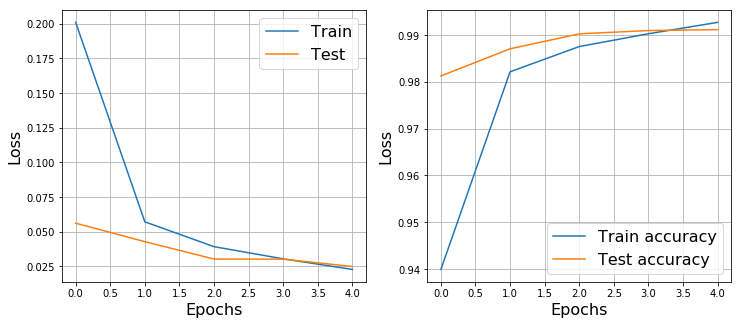

In [680]:
network3 = ThirdConvClassifier(image_size=28)
train(network3, 5, 1e-4)

In [710]:
class FourthConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(FourthConvClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(4, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 64, 3, padding=1),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(image_size//2*image_size//2*64, 10), 
            nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.085/0.076	Accuracy: 0.975/0.977


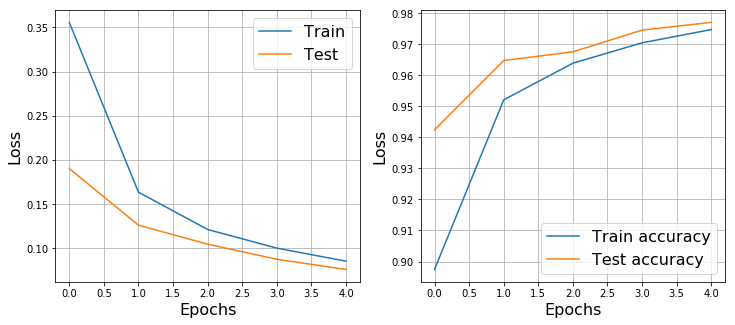

In [711]:
network4 = FourthConvClassifier(image_size=28)
train(network4, 5, 1e-4)

не получилось

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: